### Verify GPU

In [1]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


import numpy as np
import torch
import pandas as pd
from glob import glob

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline
# check if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("Training on GPU")
else:
    print("Training on CPU")

Training on GPU


### Load Data

In [2]:
data = pd.read_csv('meta.csv')

In [3]:
data.head()

,age,gender,path
0,45,male,data/imdb_crop/02/nm0000102_rm519346944_1958-7...
1,51,male,data/imdb_crop/01/nm0000501_rm3903953152_1954-...
2,24,male,data/imdb_crop/39/nm1027039_rm748338944_1986-9...
3,19,female,data/imdb_crop/43/nm1086543_rm4160587008_1985-...
4,50,male,data/wiki_crop/36/5674636_1957-09-19_2008.jpg


In [4]:
data.columns

Index(['age', 'gender', 'path'], dtype='object')

In [5]:
data.shape

(224558, 3)

### Clearning up the dataset

In [6]:
data = data.drop([index for index, age in enumerate(data["age"]) if age <0])

In [7]:
data.shape

(224558, 3)

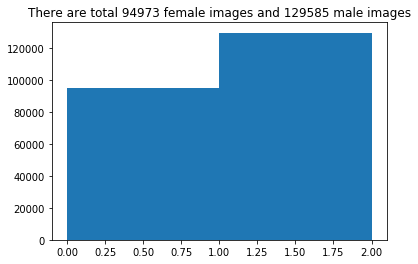

In [8]:
gender = []
for g in data['gender'].values:
    if g == 'male':
        gender.append(1)
    else:
        gender.append(0)
            

plt.hist(gender, range(3))
plt.title('There are total ' + str(len(gender) - sum(gender)) + ' female images and ' + str(sum(gender)) + ' male images')
plt.show()

# min age: 0
# max age: 99


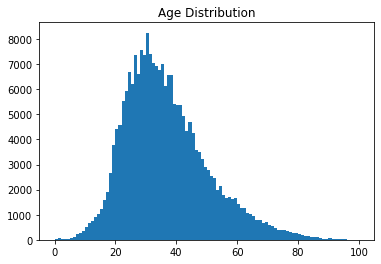

0


In [9]:
min_age, max_age = data["age"].min(), data["age"].max()
print("# min age: {}".format(min_age))
print("# max age: {}".format(max_age))
plt.hist(data['age'], range(0, 101))
plt.title('Age Distribution')
plt.show()

from pprint import pprint as pp
negative_ages = [data[["age","path"]].loc[index,:] for index, age in enumerate(data["age"]) if age <0 or age>101]
print(len(negative_ages))

### Load, Transform and Generete Loader

In [10]:
from torch.utils.data.sampler import SubsetRandomSampler

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# define training and test data directories
data_dir = 'dataset/'
age_train_dir = os.path.join(data_dir, "age/train")
age_test_dir = os.path.join(data_dir, "age/test")
gender_train_dir = os.path.join(data_dir, "gender/train")
gender_test_dir = os.path.join(data_dir, "gender/test")

age_files_dataset = age_train_dir+"/*/*"
age_files_array = np.array(glob(age_files_dataset))

validation_split = .2
train_dataset_size = len(age_files_array)
indices = list(range(train_dataset_size))
shuffle_dataset = True
random_seed = 42
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
split = int(np.floor(validation_split*train_dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

sizetoCrop = 224
data_transforms_train = transforms.Compose([
            #transforms.RandomHorizontalFlip(),
            #transforms.RandomRotation(20),
            #transforms.RandomResizedCrop(sizetoCrop),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
        ])

data_transforms_valid_test = transforms.Compose([transforms.Resize(256), 
                                         transforms.CenterCrop(224), 
                                         transforms.ToTensor(), 
                                         transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                              std=[0.5, 0.5, 0.5])])


age_train_data = datasets.ImageFolder(age_train_dir, transform = data_transforms_train)
age_test_data = datasets.ImageFolder(age_test_dir, transform = data_transforms_valid_test)

gender_train_data = datasets.ImageFolder(gender_train_dir, transform = data_transforms_train)
gender_test_data = datasets.ImageFolder(gender_test_dir, transform = data_transforms_valid_test)

print("********************datasets.ImageFolder**********************")
print(f"# age_train_data = {len(age_train_data)}")
print(f"# age_test_data = {len(age_test_data)}")
print(f"# gender_train_data = {len(gender_train_data)}")
print(f"# gender_test_data = {len(gender_test_data)}")
print("**************************************************************")

# define dataloader parameters
batch_size = 20
num_workers = 0

age_train_loader = torch.utils.data.DataLoader(age_train_data, batch_size= batch_size, 
                                            num_workers = num_workers,
                                            sampler=train_sampler)

age_valid_loader = torch.utils.data.DataLoader(age_train_data, batch_size= batch_size,
                                             num_workers = num_workers,
                                             sampler=valid_sampler)


age_test_loader = torch.utils.data.DataLoader(age_test_data, batch_size = batch_size,
                                             num_workers = num_workers,
                                             shuffle = True)

gender_train_loader = torch.utils.data.DataLoader(gender_train_data, batch_size= batch_size, 
                                            num_workers = num_workers,
                                            shuffle = True)

gender_test_loader = torch.utils.data.DataLoader(gender_test_data, batch_size = batch_size,
                                            num_workers = num_workers,
                                            shuffle = True)

print("*****************torch.utils.data.DataLoader******************")
print(f"# age_train_loader = {len(age_train_loader)}")
print(f"# age_valid_loader = {len(age_valid_loader)}")
print(f"# age_test_loader = {len(age_test_loader)}")
print(f"# gender_train_loader = {len(gender_train_loader)}")
print(f"# gender_test_loader = {len(gender_test_loader)}")
print("**************************************************************")

********************datasets.ImageFolder**********************
# age_train_data = 179646
# age_test_data = 44912
# gender_train_data = 171262
# gender_test_data = 53296
**************************************************************
*****************torch.utils.data.DataLoader******************
# age_train_loader = 7186
# age_valid_loader = 1797
# age_test_loader = 2246
# gender_train_loader = 8564
# gender_test_loader = 2665
**************************************************************


### Visualize faces/age

In [11]:
dataiter = iter(age_train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)
print(labels.min())
print(labels.max())

torch.Size([20, 3, 128, 128])
torch.Size([20])
tensor(16)
tensor(61)


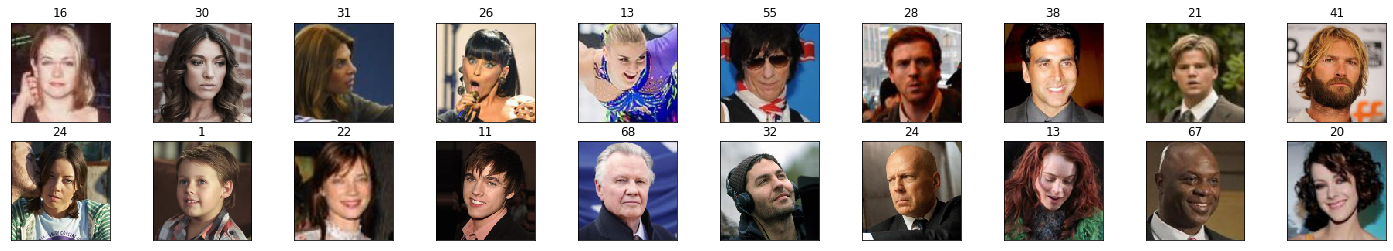

In [12]:
# Visualize some sample data
age_classes = list(range(101))
# obtain one batch of training images
dataiter = iter(age_train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(age_classes[labels[idx]])

### Visualize faces/gender

In [13]:
dataiter = iter(gender_train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([20, 3, 128, 128])
torch.Size([20])


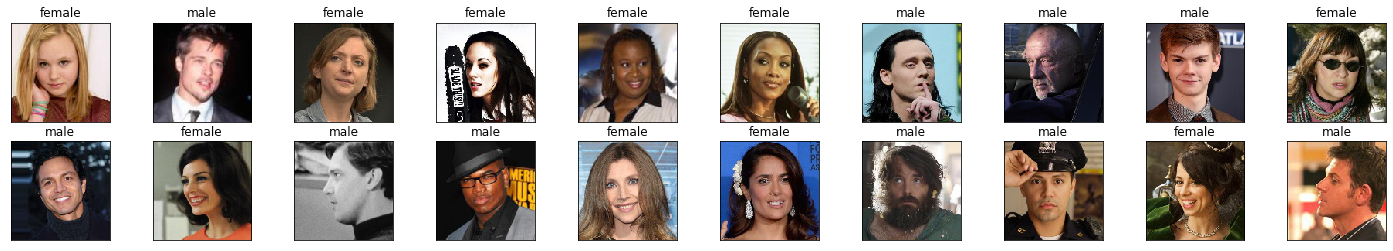

In [14]:
# Visualize some sample data
gender_classes = ["female", "male"]
# obtain one batch of training images
dataiter = iter(gender_train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(gender_classes[labels[idx]])

### Detect Human Faces using LandMarks

Number of faces detected in image: 1


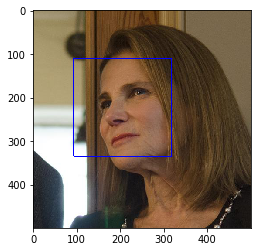

In [15]:
import cv2   
from glob import glob

# Get all the files
faces_files = np.array(glob("data/*/*/*"))

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(faces_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected in image:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plottingerror: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/objdetect/src/cascadedetect.cpp:1698: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Implementing model  Architecture GVV16

In [16]:

import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()

### Final Classifier Layer

Once you have the pre-trained feature extractor, you just need to modify and/or add to the final, fully-connected classifier layers. In this case, we suggest that you repace the last layer in the vgg classifier group of layers.

In [17]:
#"Freeze" all the parameters, so the net acts as a fixed feature extractor
for param in model_transfer.parameters():
    param.requires_grad = False

### Updating Last Layer for age FC

In [18]:
#Remove the last layer and update it with the current information
age_n_classes = 100 # age [0-101]
n_input = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_input, age_n_classes) 

#Replace the last layer with a linear classifier of our own
model_transfer.classifier[6] = last_layer

if use_cuda:
    model_transfer.cuda()
    
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### Specify Loss function and optimizer

In [19]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
age_criterion_transfer = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
age_optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

### Training and validate the model

images.shape = torch.Size([20, 3, 128, 128])
target.shape = torch.Size([20])
tensor(28)


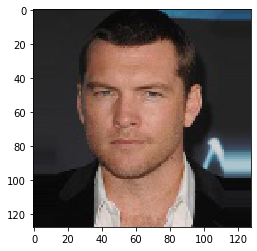

In [20]:
# create dict loaders_scratch
age_loaders_transfer = {
    "train": age_train_loader,
    "valid": age_valid_loader,
    "test": age_test_loader
}

iterator = iter(age_loaders_transfer["train"])
images, target = next(iterator)
print("images.shape = {}".format(images.shape))
print("target.shape = {}".format(target.shape))

images = images.numpy()
plt.imshow(np.transpose(images[19], (1,2,0)))
print(target[19])





## plot the images in the batch, along with the corresponding labels
#fig = plt.figure(figsize=(25, 4))
#for idx in np.arange(20):
#    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
#    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
#    ax.set_title(age_classes[labels[idx]])

In [21]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.Inf 
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        #train the model
        model.train()
        for batch_idx, (data, target) in enumerate(loaders["train"]):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))  
 
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            with torch.no_grad():
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()*data.size(0)
        
        train_loss = train_loss/len(loaders['train'].dataset) 
        valid_loss = valid_loss/len(loaders['valid'].dataset)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
        ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print("Validation loss decreassed {:.6f} --> {:.6f}"
                .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [22]:
import time

start = time.time()
n_epochs = 30
# train the model
model_transfer = train(n_epochs, age_loaders_transfer,model_transfer, age_optimizer_transfer, age_criterion_transfer, use_cuda, 'model_age_transfer.pt')
end = time.time()
elapsed_time = end - start
print("elapsed_time = {} min, {} sec".format(elapsed_time//60, elapsed_time))

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1556653114079/work/aten/src/THCUNN/generic/ClassNLLCriterion.cu:110